In [1]:
import numpy as np
import scipy.signal as ssgn
import scipy.stats as stats
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import pairwise_distances, accuracy_score, recall_score, roc_auc_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

import graphics_utility as gru

from pathlib import Path
import os
import pickle

import dtw_metrics_tslearn as dtm

In [2]:
feature16_path = Path('../data/features_16')
feature32_path = Path('../data/features_32')

In [3]:
f16_path_dictionary = {}

for sub_path in feature16_path.iterdir():
    if False==sub_path.is_dir():
        continue
    f16_path_dictionary[sub_path.name] = {'mfcc': [], 'cq': [], 'wp': []}
    for item in sub_path.iterdir():
        if False== item.is_file() or item.suffix!='.npy':
            continue
        if '_mfcc' in item.stem:
            f16_path_dictionary[sub_path.name]['mfcc'].append(item.absolute())
        elif '_cq' in item.stem:
            f16_path_dictionary[sub_path.name]['cq'].append(item.absolute())
        elif '_wp' in item.stem:
            f16_path_dictionary[sub_path.name]['wp'].append(item.absolute())
        else:
            continue
    f16_path_dictionary[sub_path.name]['mfcc'].sort()
    f16_path_dictionary[sub_path.name]['cq'].sort()
    f16_path_dictionary[sub_path.name]['wp'].sort()

In [4]:
f32_path_dictionary = {}

for sub_path in feature32_path.iterdir():
    if False==sub_path.is_dir():
        continue
    f32_path_dictionary[sub_path.name] = {'mfcc': [], 'cq': [], 'wp': []}
    for item in sub_path.iterdir():
        if False== item.is_file() or item.suffix!='.npy':
            continue
        if '_mfcc' in item.stem:
            f32_path_dictionary[sub_path.name]['mfcc'].append(item.absolute())
        elif '_cq' in item.stem:
            f32_path_dictionary[sub_path.name]['cq'].append(item.absolute())
        elif '_wp' in item.stem:
            f32_path_dictionary[sub_path.name]['wp'].append(item.absolute())
        else:
            continue
    f32_path_dictionary[sub_path.name]['mfcc'].sort()
    f32_path_dictionary[sub_path.name]['cq'].sort()
    f32_path_dictionary[sub_path.name]['wp'].sort() 

### **Эксперимент 1. Бинарная классификация голосовых команд с использованием алгоритма KNN.**
#### Строим набор данных: все произнесения выбранного слова помечаются классом 1, произнесения всех остальных слов  - классом 0.
<br></br>
#### **Использование KNN требует, чтобы все входные данные были представлены векторами одного размера.**
#### Т.е. требуется дополнительное преобразование матриц параметров.

In [5]:
def get_binary_dataset(path_dictionary, key_word, feature):
    '''
    Parameters:
    path_dictionary : dict of paths to feature files
    feature (str)   : 'wp' - wavelet packets envelopes, 'mfcc', 'cq' - constant Q spectrum
    '''
    if feature not in ['wp', 'mfcc', 'cq']:
        print("feature name can be either 'wp' or 'mfcc' or 'cq'")
        return None
    
    raw_X = []
    max_size = 0
    y = []
    label_dict = {}
    for word_idx, word in enumerate(path_dictionary.keys()):
        label_dict[word_idx] = word
        for path in path_dictionary[word][feature]:
            sample = np.load(path).flatten()
            if sample.size > max_size:
                max_size = sample.size
            raw_X.append(sample)
            if word == key_word:
                y.append(1)
            else:
                y.append(0)
            
    X = []
    for sample in raw_X:
        padded_sample = np.full(max_size, -1e5, dtype=float)
        padded_sample[0:sample.size]=sample[0:sample.size]
        X.append(padded_sample)
    return np.array(X), np.array(y)

In [6]:
X16_mfcc, y16_mfcc = get_binary_dataset(f16_path_dictionary, 'marvin', 'mfcc')

#### Размерность преобразованного набора данных:

In [7]:
X16_mfcc.shape

(200, 944)

#### Убеждаемся, что преобразование данных обратимое, восстанавливаем исходную матрицу.

In [8]:
X16_mfcc[0][X16_mfcc[0] != -1e5].reshape(16,-1).shape

(16, 28)

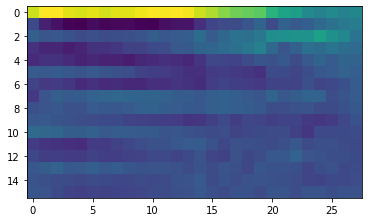

In [9]:
plt.imshow(X16_mfcc[0][X16_mfcc[0] != -1e5].reshape(16,-1))

#### **Определяем собственную функцию для вычисления меры близости в KNN**

In [10]:
def dtw_distance(a, b, num_rows, metrics, direction):
    '''
    Calculates DTW distance, used as a metric for for KNN classification.
    Parameters:
    a         : 1D (flattened) array of features
    b         : 1D (flattened) array of features
    metrics   : 'mse' - MSE between aligned features or 'dist' - DTW distance
    direction : 'row' - row-wise or 'column' - column-wise calculation metrics calculation
    '''
    # remove dummy padding values
    a_clean = a[a != -1e5]
    b_clean = b[b != -1e5]
    # restore normal 2D representation
    a_matrix = a_clean.reshape(num_rows, -1)
    b_matrix = b_clean.reshape(num_rows, -1)
    if 'row'==direction:
        distance, mse = dtm.get_row_wise_dtw_metrics(a_matrix, b_matrix)
    else:
        distance, mse = dtm.get_column_wise_dtw_metrics(a_matrix, b_matrix)
    if 'mse'==metrics:
        return mse
    else:
        return distance

#### Создаём и обучаем тестовую модель.

In [11]:
knn_classifier = KNeighborsClassifier(
    n_neighbors=5,
    metric=dtw_distance,
    metric_params={'num_rows':16, 'metrics': 'dist', 'direction': 'column'}
)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X16_mfcc, y16_mfcc,
    test_size=0.25,
    random_state=1812
)

In [13]:
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
                     metric=<function dtw_distance at 0x7f3e0a559d40>,
                     metric_params={'direction': 'column', 'metrics': 'dist',
                                    'num_rows': 16},
                     n_jobs=None, n_neighbors=5, p=2, weights='uniform')

In [14]:
y_pred = knn_classifier.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0])

In [15]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0])

In [16]:
recall_score(y_test, y_pred)

0.4

#### Получен адекватный результат. Можно провести кросс-валидацию модели
#### и сравнить точность бинарной классификации для отдельных слов.

In [17]:
def quality_report(y_true, y_pred, averaging='binary'):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=averaging)    
    rec = recall_score(y_true, y_pred, average=averaging)
    f1 = f1_score(y_true, y_pred, average=averaging)
    return acc, prec, rec, f1

In [18]:
def binary_classification_cv(
    num_features, feature, metrics, direction,
    neighbors=3, test_split_ratio=0.25,
    cv=5
):
    if 16==num_features:
        path_dictionary = f16_path_dictionary
    elif 32==num_features:
        path_dictionary = f32_path_dictionary
    else:
        print('Wrong features number!')
        return None
    
    global_quality = {}    
    for key_word in path_dictionary.keys():        
        X, y = get_binary_dataset(path_dictionary, key_word, feature)
        
        test_classifier = KNeighborsClassifier(
            n_neighbors=neighbors,
            metric=dtw_distance,
            metric_params={'num_rows': num_features, 'metrics': metrics, 'direction': direction}
        )
        
        cv_results = cross_validate(
            test_classifier,
            X, y,
            scoring=['accuracy', 'precision', 'recall', 'f1'],
            cv=cv)
        
        global_quality[key_word] = {
            'accuracy': np.mean(cv_results['test_accuracy']),
            'precision': np.mean(cv_results['test_precision']),
            'recall': np.mean(cv_results['test_recall']),
            'f1': np.mean(cv_results['test_f1'])
        }
    
    return pd.DataFrame.from_dict(global_quality)

In [19]:
#binary_16_mfcc_dist_row_5 = binary_classification_cv(
#    num_features=16,
#    feature='mfcc',
#    metrics='dist',
#    direction='row',
#    neighbors=5
#)

In [20]:
#binary_16_mfcc_dist_row_5.to_pickle('binary_16_mfcc_dist_row_5.pkl')
binary_16_mfcc_dist_row_5_backup = pd.read_pickle('binary_16_mfcc_dist_row_5.pkl')

#### Результаты кросс-валидации модели k=5, 16 коэффициентов MFCC, построчное сравнение, DTW distance.

In [21]:
binary_16_mfcc_dist_row_5_backup.style.highlight_max(axis=1).highlight_min(axis=1, color='red')

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
accuracy,0.915000,0.760000,0.975000,0.980000,0.945000,0.870000,0.955000,0.960000,0.975000,0.985000
precision,0.844444,0.354127,0.933333,0.950000,0.880000,0.770833,0.810000,0.880000,1.000000,1.000000
recall,0.500000,0.750000,0.850000,0.850000,0.600000,0.400000,0.750000,0.750000,0.750000,0.850000
f1,0.564396,0.446332,0.874286,0.892857,0.698413,0.414286,0.770635,0.768889,0.847619,0.904762


In [22]:
#binary_16_mfcc_dist_col_5 = binary_classification_cv(
#    num_features=16,
#    feature='mfcc',
#    metrics='dist',
#    direction='column',
#    neighbors=5
#)

In [23]:
#binary_16_mfcc_dist_col_5.to_pickle('binary_16_mfcc_dist_col_5.pkl')
binary_16_mfcc_dist_col_5_backup = pd.read_pickle('binary_16_mfcc_dist_col_5.pkl')

#### Результаты кросс-валидации модели k=5, 16 коэффициентов MFCC, сравнение колонок, DTW distance.

In [24]:
binary_16_mfcc_dist_col_5_backup.style.highlight_max(axis=1).highlight_min(axis=1, color='red')

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
accuracy,0.945000,0.815000,0.975000,0.965000,0.945000,0.945000,0.935000,0.970000,0.950000,0.990000
precision,0.819048,0.457143,0.864286,0.866667,0.866667,0.920000,0.720000,0.880000,0.819048,0.960000
recall,0.750000,1.000000,0.950000,0.850000,0.850000,0.550000,0.900000,1.000000,0.750000,0.950000
f1,0.735758,0.584693,0.895455,0.851429,0.814286,0.651429,0.783492,0.914286,0.766234,0.949206


In [25]:
#binary_32_mfcc_dist_row_5 = binary_classification_cv(
#    num_features=32,
#    feature='mfcc',
#    metrics='dist',
#    direction='row',
#    neighbors=5
#)

In [26]:
#binary_32_mfcc_dist_row_5.to_pickle('binary_32_mfcc_dist_row_5.pkl')
binary_32_mfcc_dist_row_5_backup = pd.read_pickle('binary_32_mfcc_dist_row_5.pkl')

#### Результаты кросс-валидации модели k=5, 32 коэффициента MFCC, построчное сравнение, DTW distance.

In [27]:
binary_32_mfcc_dist_row_5_backup.style.highlight_max(axis=1).highlight_min(axis=1, color='red')

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
accuracy,0.920000,0.745000,0.950000,0.955000,0.920000,0.895000,0.925000,0.930000,0.930000,0.970000
precision,0.816667,0.230173,0.920000,1.000000,0.773333,0.840000,0.880000,0.750000,0.920000,1.000000
recall,0.350000,0.600000,0.600000,0.550000,0.450000,0.350000,0.400000,0.650000,0.400000,0.700000
f1,0.447143,0.328880,0.704762,0.689524,0.543492,0.430476,0.500317,0.641429,0.506667,0.809524


In [28]:
#binary_32_mfcc_dist_col_5 = binary_classification_cv(
#    num_features=32,
#    feature='mfcc',
#    metrics='dist',
#    direction='column',
#    neighbors=5
#)metrics

In [29]:
#binary_32_mfcc_dist_col_5.to_pickle('binary_32_mfcc_dist_col_5.pkl')
binary_32_mfcc_dist_col_5_backup = pd.read_pickle('binary_32_mfcc_dist_col_5.pkl')

#### Результаты кросс-валидации модели k=5, 32 коэффициента MFCC, сравнение колонок, DTW distance.

In [30]:
binary_32_mfcc_dist_col_5_backup.style.highlight_max(axis=1).highlight_min(axis=1, color='red')

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
accuracy,0.925000,0.835000,0.975000,0.970000,0.940000,0.945000,0.920000,0.975000,0.935000,0.985000
precision,0.800000,0.487619,0.900000,0.880000,0.880000,0.950000,0.742857,0.888889,0.758333,0.960000
recall,0.600000,1.000000,0.950000,0.850000,0.700000,0.500000,0.850000,1.000000,0.700000,0.900000
f1,0.601212,0.613876,0.904762,0.860317,0.723810,0.630000,0.766667,0.923077,0.697619,0.920635


#### **Подбор параметров модели KNN для бинарной классификации.**

In [31]:
def binary_classification_grid_search(num_features, feature, metric, cv=5):
    if 16==num_features:
        path_dictionary = f16_path_dictionary
    elif 32==num_features:
        path_dictionary = f32_path_dictionary
    else:
        print('Wrong features number!')
        return None
    
    test_classifier = KNeighborsClassifier(metric=dtw_distance)
    param_grid = {
        'n_neighbors' : [2,4,8,12],
        'metric_params' : [
            {'num_rows': num_features, 'metrics': 'dist', 'direction': 'row'},
            {'num_rows': num_features, 'metrics': 'mse', 'direction': 'row'},
            {'num_rows': num_features, 'metrics': 'dist', 'direction': 'column'},
            {'num_rows': num_features, 'metrics': 'mse', 'direction': 'column'}
        ]
    }
    
    grid_search_results = {}
    for key_word in path_dictionary.keys():        
        X, y = get_binary_dataset(path_dictionary, key_word, feature)
        
        grid_search = GridSearchCV(test_classifier, param_grid, scoring=metric, cv=cv)
        grid_search.fit(X, y)
        grid_search_results[key_word]={'best_score': grid_search.best_score_, 'n_neighbors': grid_search.best_params_['n_neighbors']}
        grid_search_results[key_word].update(grid_search.best_params_['metric_params'])
    
    return grid_search_results    

In [32]:
#mfcc16_grid_cv_results = binary_classification_grid_search(16, 'mfcc', 'recall')

In [33]:
#pickle.dump(mfcc16_grid_cv_results, open('mfcc16_grid_cv_results.pkl', 'wb'))
mfcc16_grid_cv_results_backup = pickle.load(open('mfcc16_grid_cv_results.pkl', 'rb'))

#### Результаты подбора параметров для бинарной классификации с использованием 16-ти коэффициентов MFCC.

In [34]:
pd.DataFrame(mfcc16_grid_cv_results_backup)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
best_score,0.65,0.95,0.95,0.85,0.9,0.9,0.9,1,0.8,0.95
n_neighbors,4,8,4,4,4,2,2,4,2,2
num_rows,16,16,16,16,16,16,16,16,16,16
metrics,dist,dist,dist,dist,mse,mse,dist,dist,mse,dist
direction,column,column,column,column,column,column,column,column,column,column


In [35]:
#wp16_grid_cv_results = binary_classification_grid_search(16, 'wp', 'recall')

In [36]:
#pickle.dump(wp16_grid_cv_results, open('wp16_grid_cv_results.pkl', 'wb'))

In [37]:
wp16_grid_cv_results_backup = pickle.load(open('wp16_grid_cv_results.pkl', 'rb'))

#### Результаты подбора параметров для бинарной классификации с использованием 16-ти вэйвлет огибающих.

In [38]:
pd.DataFrame(wp16_grid_cv_results_backup)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
best_score,0.45,0.5,0.45,0.8,0.65,0.5,0.55,0.45,0.55,0.8
n_neighbors,2,2,2,2,4,4,2,4,2,2
num_rows,16,16,16,16,16,16,16,16,16,16
metrics,dist,dist,dist,dist,mse,mse,dist,dist,dist,dist
direction,column,column,column,row,column,column,column,column,row,column


#### Построение набора данных для многоклассовой классификации.

In [39]:
def get_multiclass_dataset(path_dictionary, feature, key_words=None):
    '''
    Parameters:
    path_dictionary : dict of paths to feature folders
    feature (str)   : 'wp' - wavelet packets envelopes, 'mfcc', 'cq' - constant Q spectrum
    '''
    if feature not in ['wp', 'mfcc', 'cq']:
        print("feature name can be either 'wp' or 'mfcc' or 'cq'")
        return None
    
    raw_X = []
    max_size = 0
    y = []
    label_dict = {}
    if key_words is None:
        key_words = list(path_dictionary.keys())
    for word_idx, word in enumerate(path_dictionary.keys()):
        if word in key_words:
            label_dict[word] = key_words.index(word)+1
        else:
            label_dict[word] = 0
            
        for path in path_dictionary[word][feature]:
            sample = np.load(path).flatten()
            if sample.size > max_size:
                max_size = sample.size
            raw_X.append(sample)
            if word in key_words:
                y.append(key_words.index(word)+1)
            else:
                y.append(0)
            
    X = []
    for sample in raw_X:
        padded_sample = np.full(max_size, -1e5)
        padded_sample[0:sample.size]=sample[0:sample.size]
        X.append(padded_sample)
    return np.array(X), np.array(y), label_dict

#### **Эксперимент 2. Распознавание пар команд.**
##### **По результатам предыдущего эксперимента определён оптимальный набор:**
##### **параметры - 16 коэффициентов MFCC, число "соседей" для KNN - 4,**
##### **сравнение матриц параметров - колонками, мера близости - DTW distance.**

In [40]:
def word_pairs_classification_cv(
    num_features, feature, metrics, direction,
    neighbors=4,
    cv=5
):
    if 16==num_features:
        path_dictionary = f16_path_dictionary
    elif 32==num_features:
        path_dictionary = f32_path_dictionary
    else:
        print('Wrong features number!')
        return None
    
    global_quality = {
        'accuracy': {},
        'precision': {},
        'recall': {},
        'f1': {}
    }
    test_classifier = KNeighborsClassifier(
        n_neighbors=neighbors,
        metric=dtw_distance,
        metric_params={'num_rows': num_features, 'metrics': metrics, 'direction': direction}
    )
    for word1 in path_dictionary.keys():
        for key in global_quality.keys():
            global_quality[key][word1] = {}
        for word2 in path_dictionary.keys():
            # skip pairs of the same word
            if word2 == word1:
                for key in global_quality.keys():
                    global_quality[key][word1][word2] = 0.0                
                continue
            # skip the pair (word1,word2) if the pair (word2, word1) is processed already
            if (word2 in global_quality['recall']) and (word1 in global_quality['recall'][word2]):
                for key in global_quality.keys():
                    global_quality[key][word1][word2] = global_quality[key][word2][word1]                
                continue
            
            X, y, _ = get_multiclass_dataset(path_dictionary, feature, key_words=[word1, word2])
        
            cv_results = cross_validate(
                test_classifier,
                X, y,
                scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                cv=cv
            )
        
            pair_results = {
                'accuracy': np.mean(cv_results['test_accuracy']),
                'precision': np.mean(cv_results['test_precision_macro']),
                'recall': np.mean(cv_results['test_recall_macro']),
                'f1': np.mean(cv_results['test_f1_macro'])
            }           
            
            for key in global_quality.keys():                
                global_quality[key][word1][word2] = pair_results[key]
    
    return global_quality

In [41]:
#pairs_16_mfcc_dist_row_4 = word_pairs_classification_cv(
#    num_features=16,
#    feature='mfcc',
#    metrics='dist',
#    direction='row',
#    neighbors=4,
#    cv=5
#)

In [42]:
#pickle.dump(pairs_16_mfcc_dist_row_4, open('pairs_16_mfcc_dist_row_4.pkl', 'wb'))
pairs_16_mfcc_dist_row_4_backup = pickle.load(open('pairs_16_mfcc_dist_row_4.pkl', 'rb'))

#### Далее приведены 4 таблицы с разными метриками качества распознавания
#### пар команд с использованием 16 коэффициентов MFCC и построчным сравнением матриц признаков.

In [43]:
pd.DataFrame(pairs_16_mfcc_dist_row_4_backup['accuracy']).style.highlight_max(axis=1)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
bird,0.000000,0.740000,0.880000,0.890000,0.880000,0.890000,0.865000,0.870000,0.850000,0.890000
bed,0.740000,0.000000,0.805000,0.780000,0.805000,0.735000,0.715000,0.780000,0.795000,0.815000
seven,0.880000,0.805000,0.000000,0.930000,0.930000,0.885000,0.900000,0.955000,0.940000,0.965000
four,0.890000,0.780000,0.930000,0.000000,0.890000,0.860000,0.935000,0.915000,0.905000,0.940000
zero,0.880000,0.805000,0.930000,0.890000,0.000000,0.820000,0.875000,0.885000,0.875000,0.910000
marvin,0.890000,0.735000,0.885000,0.860000,0.820000,0.000000,0.830000,0.850000,0.850000,0.880000
dog,0.865000,0.715000,0.900000,0.935000,0.875000,0.830000,0.000000,0.925000,0.910000,0.935000
cat,0.870000,0.780000,0.955000,0.915000,0.885000,0.850000,0.925000,0.000000,0.910000,0.950000
happy,0.850000,0.795000,0.940000,0.905000,0.875000,0.850000,0.910000,0.910000,0.000000,0.930000
eight,0.890000,0.815000,0.965000,0.940000,0.910000,0.880000,0.935000,0.950000,0.930000,0.000000


In [44]:
pd.DataFrame(pairs_16_mfcc_dist_row_4_backup['precision']).style.highlight_max(axis=1)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
bird,0.000000,0.689261,0.802434,0.847477,0.823899,0.813466,0.768971,0.817882,0.786134,0.845216
bed,0.689261,0.000000,0.726274,0.721058,0.762013,0.686670,0.603832,0.736866,0.760190,0.794241
seven,0.802434,0.726274,0.000000,0.924204,0.912599,0.921837,0.856370,0.962260,0.977015,0.986215
four,0.847477,0.721058,0.924204,0.000000,0.873032,0.868584,0.875396,0.882707,0.894784,0.924337
zero,0.823899,0.762013,0.912599,0.873032,0.000000,0.825471,0.830216,0.868447,0.906123,0.919151
marvin,0.813466,0.686670,0.921837,0.868584,0.825471,0.000000,0.846714,0.875493,0.848431,0.921003
dog,0.768971,0.603832,0.856370,0.875396,0.830216,0.846714,0.000000,0.904663,0.925219,0.924708
cat,0.817882,0.736866,0.962260,0.882707,0.868447,0.875493,0.904663,0.000000,0.922897,0.960866
happy,0.786134,0.760190,0.977015,0.894784,0.906123,0.848431,0.925219,0.922897,0.000000,0.958579
eight,0.845216,0.794241,0.986215,0.924337,0.919151,0.921003,0.924708,0.960866,0.958579,0.000000


In [45]:
pd.DataFrame(pairs_16_mfcc_dist_row_4_backup['recall']).style.highlight_max(axis=1)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
bird,0.000000,0.658333,0.716667,0.677083,0.672917,0.647917,0.695833,0.654167,0.631250,0.706250
bed,0.658333,0.000000,0.787500,0.747917,0.700000,0.641667,0.691667,0.747917,0.710417,0.762500
seven,0.716667,0.787500,0.000000,0.854167,0.795833,0.733333,0.827083,0.864583,0.800000,0.883333
four,0.677083,0.747917,0.854167,0.000000,0.735417,0.693750,0.856250,0.804167,0.756250,0.843750
zero,0.672917,0.700000,0.795833,0.735417,0.000000,0.589583,0.743750,0.718750,0.670833,0.758333
marvin,0.647917,0.641667,0.733333,0.693750,0.589583,0.000000,0.666667,0.675000,0.645833,0.716667
dog,0.695833,0.691667,0.827083,0.856250,0.743750,0.666667,0.000000,0.822917,0.729167,0.827083
cat,0.654167,0.747917,0.864583,0.804167,0.718750,0.675000,0.822917,0.000000,0.758333,0.847917
happy,0.631250,0.710417,0.800000,0.756250,0.670833,0.645833,0.729167,0.758333,0.000000,0.781250
eight,0.706250,0.762500,0.883333,0.843750,0.758333,0.716667,0.827083,0.847917,0.781250,0.000000


In [46]:
pd.DataFrame(pairs_16_mfcc_dist_row_4_backup['f1']).style.highlight_max(axis=1)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
bird,0.000000,0.607242,0.729004,0.729431,0.708184,0.680941,0.707348,0.694623,0.653155,0.747927
bed,0.607242,0.000000,0.733168,0.706038,0.696688,0.593721,0.609599,0.701410,0.693677,0.755999
seven,0.729004,0.733168,0.000000,0.870519,0.817064,0.764835,0.825831,0.893811,0.855964,0.923072
four,0.729431,0.706038,0.870519,0.000000,0.769584,0.719357,0.861274,0.819649,0.792469,0.872442
zero,0.708184,0.696688,0.817064,0.769584,0.000000,0.633590,0.767819,0.757363,0.735217,0.807226
marvin,0.680941,0.593721,0.764835,0.719357,0.633590,0.000000,0.689782,0.697845,0.676698,0.751259
dog,0.707348,0.609599,0.825831,0.861274,0.767819,0.689782,0.000000,0.843081,0.784655,0.864567
cat,0.694623,0.701410,0.893811,0.819649,0.757363,0.697845,0.843081,0.000000,0.794893,0.880262
happy,0.653155,0.693677,0.855964,0.792469,0.735217,0.676698,0.784655,0.794893,0.000000,0.834158
eight,0.747927,0.755999,0.923072,0.872442,0.807226,0.751259,0.864567,0.880262,0.834158,0.000000


In [47]:
#pairs_16_mfcc_dist_col_4 = word_pairs_classification_cv(
#    num_features=16,
#    feature='mfcc',
#    metrics='dist',
#    direction='column',
#    neighbors=4,
#    cv=5
#)

In [48]:
#pickle.dump(pairs_16_mfcc_dist_col_4, open('pairs_16_mfcc_dist_col_4.pkl', 'wb'))
pairs_16_mfcc_dist_col_4_backup = pickle.load(open('pairs_16_mfcc_dist_col_4.pkl', 'rb'))

#### Далее приведены 4 таблицы с разными метриками качества распознавания
#### пар команд с использованием 16 коэффициентов MFCC и сравнением колонок матриц признаков.

In [49]:
pd.DataFrame(pairs_16_mfcc_dist_col_4_backup['accuracy']).style.highlight_max(axis=1)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
bird,0.000000,0.830000,0.900000,0.925000,0.930000,0.915000,0.875000,0.915000,0.880000,0.920000
bed,0.830000,0.000000,0.845000,0.860000,0.870000,0.825000,0.770000,0.800000,0.770000,0.860000
seven,0.900000,0.845000,0.000000,0.950000,0.975000,0.925000,0.880000,0.965000,0.935000,0.970000
four,0.925000,0.860000,0.950000,0.000000,0.915000,0.935000,0.955000,0.955000,0.930000,0.975000
zero,0.930000,0.870000,0.975000,0.915000,0.000000,0.885000,0.900000,0.925000,0.900000,0.935000
marvin,0.915000,0.825000,0.925000,0.935000,0.885000,0.000000,0.885000,0.930000,0.900000,0.935000
dog,0.875000,0.770000,0.880000,0.955000,0.900000,0.885000,0.000000,0.930000,0.895000,0.935000
cat,0.915000,0.800000,0.965000,0.955000,0.925000,0.930000,0.930000,0.000000,0.945000,0.985000
happy,0.880000,0.770000,0.935000,0.930000,0.900000,0.900000,0.895000,0.945000,0.000000,0.940000
eight,0.920000,0.860000,0.970000,0.975000,0.935000,0.935000,0.935000,0.985000,0.940000,0.000000


In [50]:
pd.DataFrame(pairs_16_mfcc_dist_col_4_backup['precision']).style.highlight_max(axis=1)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
bird,0.000000,0.775023,0.875364,0.913663,0.927295,0.894544,0.815285,0.864220,0.832734,0.866619
bed,0.775023,0.000000,0.788162,0.808959,0.836650,0.817638,0.711820,0.798239,0.761289,0.844198
seven,0.875364,0.788162,0.000000,0.951198,0.963939,0.876520,0.848626,0.935873,0.926240,0.949091
four,0.913663,0.808959,0.951198,0.000000,0.916086,0.975413,0.937670,0.924905,0.922698,0.978642
zero,0.927295,0.836650,0.963939,0.916086,0.000000,0.858824,0.875489,0.919012,0.910667,0.934197
marvin,0.894544,0.817638,0.876520,0.975413,0.858824,0.000000,0.877867,0.883476,0.873153,0.897060
dog,0.815285,0.711820,0.848626,0.937670,0.875489,0.877867,0.000000,0.891034,0.838715,0.904252
cat,0.864220,0.798239,0.935873,0.924905,0.919012,0.883476,0.891034,0.000000,0.941023,0.975758
happy,0.832734,0.761289,0.926240,0.922698,0.910667,0.873153,0.838715,0.941023,0.000000,0.926853
eight,0.866619,0.844198,0.949091,0.978642,0.934197,0.897060,0.904252,0.975758,0.926853,0.000000


In [51]:
pd.DataFrame(pairs_16_mfcc_dist_col_4_backup['recall']).style.highlight_max(axis=1)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
bird,0.000000,0.856250,0.827083,0.822917,0.825000,0.760417,0.831250,0.833333,0.745833,0.835417
bed,0.856250,0.000000,0.906250,0.883333,0.858333,0.795833,0.860417,0.858333,0.802083,0.897917
seven,0.827083,0.906250,0.000000,0.920833,0.916667,0.793750,0.935417,0.970833,0.841667,0.958333
four,0.822917,0.883333,0.920833,0.000000,0.862500,0.783333,0.952083,0.937500,0.810417,0.931250
zero,0.825000,0.858333,0.916667,0.862500,0.000000,0.733333,0.900000,0.925000,0.797917,0.914583
marvin,0.760417,0.795833,0.793750,0.783333,0.733333,0.000000,0.791667,0.810417,0.695833,0.797917
dog,0.831250,0.860417,0.935417,0.952083,0.900000,0.791667,0.000000,0.956250,0.810417,0.943750
cat,0.833333,0.858333,0.970833,0.937500,0.925000,0.810417,0.956250,0.000000,0.875000,0.979167
happy,0.745833,0.802083,0.841667,0.810417,0.797917,0.695833,0.810417,0.875000,0.000000,0.843750
eight,0.835417,0.897917,0.958333,0.931250,0.914583,0.797917,0.943750,0.979167,0.843750,0.000000


In [52]:
pd.DataFrame(pairs_16_mfcc_dist_col_4_backup['f1']).style.highlight_max(axis=1)

,bird,bed,seven,four,zero,marvin,dog,cat,happy,eight
bird,0.000000,0.761522,0.816781,0.838812,0.850547,0.786832,0.788584,0.823550,0.758427,0.828063
bed,0.761522,0.000000,0.808589,0.813897,0.818148,0.759061,0.728242,0.769559,0.708261,0.833235
seven,0.816781,0.808589,0.000000,0.919219,0.934754,0.810259,0.861609,0.947572,0.867836,0.950017
four,0.838812,0.813897,0.919219,0.000000,0.869133,0.834102,0.937178,0.925665,0.850876,0.946194
zero,0.850547,0.818148,0.934754,0.869133,0.000000,0.748068,0.863066,0.900691,0.824466,0.906511
marvin,0.786832,0.759061,0.810259,0.834102,0.748068,0.000000,0.783342,0.819628,0.746579,0.822132
dog,0.788584,0.728242,0.861609,0.937178,0.863066,0.783342,0.000000,0.907304,0.803541,0.909749
cat,0.823550,0.769559,0.947572,0.925665,0.900691,0.819628,0.907304,0.000000,0.882013,0.973967
happy,0.758427,0.708261,0.867836,0.850876,0.824466,0.746579,0.803541,0.882013,0.000000,0.858249
eight,0.828063,0.833235,0.950017,0.946194,0.906511,0.822132,0.909749,0.973967,0.858249,0.000000


#### **Основной эксперимент. Испытание предложенного алгоритма. Распознавание 10-ти различных команд.**

In [53]:
def multiclass_classification_cv(
    num_features, feature, metrics, direction,
    neighbors=4,
    num_splits=[5],
    num_iters=10
):
    if 16==num_features:
        path_dictionary = f16_path_dictionary
    elif 32==num_features:
        path_dictionary = f32_path_dictionary
    else:
        print('Wrong features number!')
        return None
    
    global_quality = {
        'accuracy': {},
        'precision': {},
        'recall': {},
        'f1': {}
    }
    
    confusion_matrices = {}
    
    test_classifier = KNeighborsClassifier(
        n_neighbors=neighbors,
        metric=dtw_distance,
        metric_params={'num_rows': num_features, 'metrics': metrics, 'direction': direction}
    )
    
    X, y, label_dict = get_multiclass_dataset(path_dictionary, feature, key_words=None)

    for splits in num_splits:
        iter_accuracies = []
        iter_precisions = []
        iter_recalls = []
        iter_f1s = []
        iter_confusions = []
        for iter_idx in range(num_iters):
            skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1812 + splits*iter_idx)
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
            
                test_classifier.fit(X_train, y_train)
            
                y_pred = test_classifier.predict(X_test)
            
                acc, prec, rec, f1 = quality_report(y_test, y_pred, averaging='macro')            
            
                iter_accuracies.append(np.mean(acc))
                iter_precisions.append(np.mean(prec))
                iter_recalls.append(np.mean(rec))
                iter_f1s.append(np.mean(f1))
                
                iter_confusions.append(confusion_matrix(y_test, y_pred, normalize=None))
        
        global_quality['accuracy'][splits] = np.mean(iter_accuracies)
        global_quality['precision'][splits] = np.mean(iter_precisions)
        global_quality['recall'][splits] = np.mean(iter_recalls)
        global_quality['f1'][splits] = np.mean(iter_f1s)
        
        sum_iter_confusions = np.sum(iter_confusions, axis=0)
        confusion_matrices[splits] = sum_iter_confusions / np.sum(sum_iter_confusions[0])

    return global_quality, confusion_matrices, label_dict

In [54]:
#multi_16_mfcc_dist_col_4_quality, multi_16_mfcc_dist_col_4_confusion, label_dict \
#= multiclass_classification_cv(
#    num_features=16,
#    feature='mfcc',
#    metrics='dist',
#    direction='column',
#    neighbors=4,
#    num_splits=[2, 4, 5],
#    num_iters=10
#)

In [55]:
#pd.DataFrame(multi_16_mfcc_dist_col_4_quality).to_pickle('multi_16_mfcc_dist_col_4_quality.pkl')
multi_16_mfcc_dist_col_4_quality_backup = pd.read_pickle('multi_16_mfcc_dist_col_4_quality.pkl')
multi_16_mfcc_dist_col_4_quality_backup

,accuracy,precision,recall,f1
2,0.838,0.885440,0.838,0.837707
4,0.862,0.904702,0.862,0.858111
5,0.880,0.913278,0.880,0.875730


In [56]:
#pd.DataFrame(
#    multi_16_mfcc_dist_col_4_confusion[2],
#    columns=list(label_dict.keys()),
#    index=list(label_dict.keys())
#).to_pickle('multi_16_mfcc_dist_col_4_confusion_2.pkl')
multi_16_mfcc_dist_col_4_confusion_2 = pd.read_pickle('multi_16_mfcc_dist_col_4_confusion_2.pkl')

#### Результаты кросс-валидации модели: 16 MFCC, k=4, DTW distance, сравнение колонок.
#### Соотношение размеров обучающей и тестовой выборок 1 : 1.

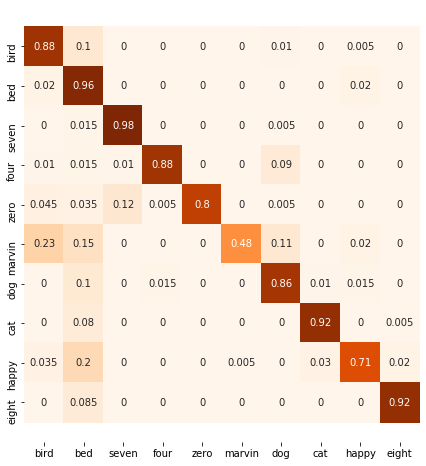

In [57]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(multi_16_mfcc_dist_col_4_confusion_2, annot=True, square=True, cmap='Oranges', ax=ax, cbar=False)
bottom, top = ax.get_ylim();
ax.set_ylim(bottom + 0.5, top - 0.5);

In [58]:
#pd.DataFrame(
#    multi_16_mfcc_dist_col_4_confusion[4],
#    columns=list(label_dict.keys()),
#    index=list(label_dict.keys())
#).to_pickle('multi_16_mfcc_dist_col_4_confusion_4.pkl')
multi_16_mfcc_dist_col_4_confusion_4 = pd.read_pickle('multi_16_mfcc_dist_col_4_confusion_4.pkl')

#### Результаты кросс-валидации модели: 16 MFCC, k=4, DTW distance, сравнение колонок.
#### Соотношение размеров обучающей и тестовой выборок 3 : 1.

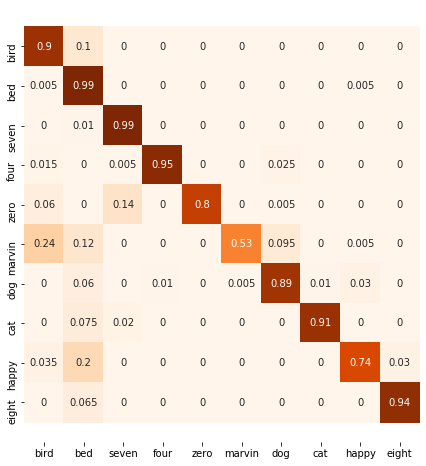

In [59]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(multi_16_mfcc_dist_col_4_confusion_4, annot=True, square=True, cmap='Oranges', ax=ax, cbar=False)
bottom, top = ax.get_ylim();
ax.set_ylim(bottom + 0.5, top - 0.5);

In [60]:
#pd.DataFrame(
#    multi_16_mfcc_dist_col_4_confusion[5],
#    columns=list(label_dict.keys()),
#    index=list(label_dict.keys())
#).to_pickle('multi_16_mfcc_dist_col_4_confusion_5.pkl')
multi_16_mfcc_dist_col_4_confusion_5 = pd.read_pickle('multi_16_mfcc_dist_col_4_confusion_5.pkl')

#### Результаты кросс-валидации модели: 16 MFCC, k=4, DTW distance, сравнение колонок.
#### Соотношение размеров обучающей и тестовой выборок 4 : 1.

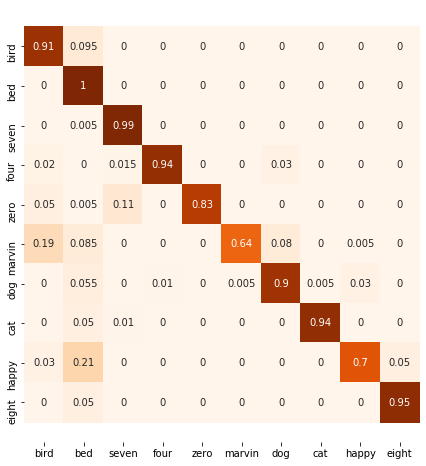

In [61]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(multi_16_mfcc_dist_col_4_confusion_5, annot=True, square=True, cmap='Oranges', ax=ax, cbar=False)
bottom, top = ax.get_ylim();
ax.set_ylim(bottom + 0.5, top - 0.5);

In [62]:
#multi_16_cq_dist_col_4_quality, multi_16_cq_dist_col_4_confusion, label_dict \
#= multiclass_classification_cv(
#    num_features=16,
#    feature='cq',
#    metrics='dist',
#    direction='column',
#    neighbors=4,
#    num_splits=[2, 4, 5],
#    num_iters=10
#)

#### Результаты кросс-валидации модели: 16 Constant-Q коэффициентов, k=4, DTW distance, сравнение колонок.

In [63]:
#pd.DataFrame(multi_16_cq_dist_col_4_quality).to_pickle('multi_16_cq_dist_col_4_quality.pkl')
multi_16_cq_dist_col_4_quality_backup = pd.read_pickle('multi_16_cq_dist_col_4_quality.pkl')
multi_16_cq_dist_col_4_quality_backup

,accuracy,precision,recall,f1
2,0.4090,0.516891,0.4090,0.400011
4,0.4475,0.531374,0.4475,0.435277
5,0.4590,0.534985,0.4590,0.444084


In [64]:
#multi_16_cq_dist_row_4_quality, _, _ \
#= multiclass_classification_cv(
#    num_features=16,
#    feature='cq',
#    metrics='dist',
#    direction='row',
#    neighbors=4,
#    num_splits=[2, 4, 5],
#    num_iters=10
#)

#### Результаты кросс-валидации модели: 16 вэйвлет-огибающих, k=4, DTW distance, сравнение колонок.

In [65]:
#pd.DataFrame(multi_16_cq_dist_row_4_quality).to_pickle('multi_16_cq_dist_row_4_quality.pkl')
multi_16_cq_dist_row_4_quality_backup = pd.read_pickle('multi_16_cq_dist_row_4_quality.pkl')
multi_16_cq_dist_row_4_quality_backup

,accuracy,precision,recall,f1
2,0.4050,0.531317,0.4050,0.411111
4,0.4285,0.542954,0.4285,0.432365
5,0.4430,0.553023,0.4430,0.445976


### **ВЫВОДЫ**
### 1. Предложенный алгоритм (KNN с использованием DTW) оказался работоспособным.
### 2. Выбран оптимальный параметр для описания звукового сигнала - 16 мел-кепстральных коэффициентов (MFCC).
### 3. Для большинства команд точность распознавания составила не менее 90%.
### 4. При этом некторые команды распознаются намного хуже - с точностью около 70%.